In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_dir = './drive/MyDrive/MangoLeaf/'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['.DS_Store', 'valid', 'train', 'test']
['.DS_Store', 'Sooty Mould', 'Powdery Mildew', 'Gall Midge', 'Cutting Weevil', 'Healthy', 'Die Back', 'Bacterial Canker', 'Anthracnose']


In [ ]:
train_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
valid_dataset = ImageFolder(data_dir+'/valid', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 320, 240]) 0


In [ ]:
print(train_dataset.classes)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [ ]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
#show_example(*train_dataset[0])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
batch_size=14
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(valid_dataset, batch_size*2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([14, 3, 320, 240])
out.shape: torch.Size([14, 8, 160, 120])


In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MangoLeaf(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #3 320 240 
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            #32 320 240
            nn.ReLU(),
            #32 320 240
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #64 320 240
            nn.ReLU(),
            #64 320 240
            nn.MaxPool2d(2, 2),
            #64 160 120

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # 128 160 120
            nn.ReLU(),
            # 128 160 120
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            # 128 160 120
            nn.ReLU(),
            # 128 160 120
            nn.MaxPool2d(2, 2),
            # 128 80 60

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            # 256 80 60
            nn.ReLU(),
            # 256 80 60
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            # 256 80 60
            nn.ReLU(),
            # 256 80 60
            nn.MaxPool2d(2, 2),
            # 256 40 30

            nn.Flatten(), 
            nn.Linear(256*40*30, 1024),   
            nn.ReLU(),
            nn.Linear(1024, 512),     
            nn.ReLU(),
            nn.Linear(512, 8),
            nn.Softmax())
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = MangoLeaf()
model

MangoLeaf(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=307200, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([14, 3, 320, 240])
out.shape: torch.Size([14, 8])
out[0]: tensor([0.1254, 0.1223, 0.1270, 0.1233, 0.1201, 0.1235, 0.1289, 0.1293],
       grad_fn=<SelectBackward0>)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(MangoLeaf(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.07949161529541, 'val_acc': 0.12929894030094147}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.0943, val_loss: 2.0795, val_acc: 0.1250
Epoch [1], train_loss: 2.0796, val_loss: 2.0795, val_acc: 0.1250
Epoch [2], train_loss: 2.0795, val_loss: 2.0795, val_acc: 0.1250
Epoch [3], train_loss: 2.0795, val_loss: 2.0795, val_acc: 0.1250
Epoch [4], train_loss: 2.0795, val_loss: 2.0795, val_acc: 0.1250
Epoch [5], train_loss: 2.0796, val_loss: 2.0795, val_acc: 0.1250
Epoch [6], train_loss: 2.0795, val_loss: 2.0795, val_acc: 0.1250
Epoch [7], train_loss: 2.0795, val_loss: 2.0795, val_acc: 0.1250
Epoch [8], train_loss: 2.0795, val_loss: 2.0795, val_acc: 0.1250
Epoch [9], train_loss: 2.0795, val_loss: 2.0795, val_acc: 0.1250


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

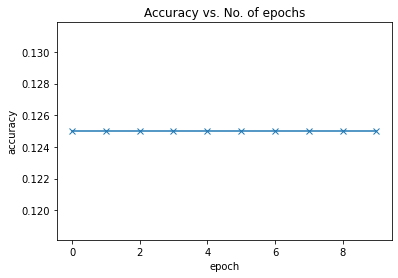

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

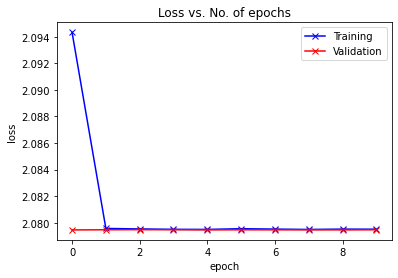

In [ ]:
plot_losses(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label: Anthracnose , Predicted: Gall Midge


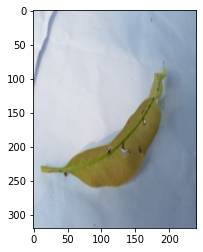

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Cutting Weevil , Predicted: Gall Midge


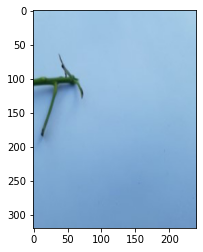

In [ ]:
img, label = test_dataset[40]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Healthy , Predicted: Gall Midge


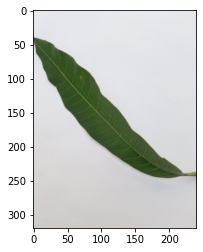

In [ ]:
img, label = test_dataset[75]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 2.079448938369751, 'val_acc': 0.125}

In [ ]:
#torch.save(model.state_dict(), 'mangoleaf.pth')